In [26]:
import torch
from torchvision import datasets,transforms
from torch.utils.data import DataLoader


In [27]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])
training_dataset=datasets.FashionMNIST(
    root="/home/sachchida/gitrepo/Deeplearning/data/fashion",
    train=True,
    download=True,
    transform=transform
)
testing_dataset=datasets.FashionMNIST(
    root="/home/sachchida/gitrepo/Deeplearning/data/fashion",
    train=False,
    transform=transform
)

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.71MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 184kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.91MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 33.8MB/s]


In [28]:
train_loader=DataLoader(training_dataset,shuffle=True,batch_size=64)
test_loader=DataLoader(testing_dataset,shuffle=True,batch_size=64)

In [29]:
import torch.nn as nn
import torch.nn.functional as F


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [31]:
class FashionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = FashionCNN().to(device)

In [32]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --------------------------------------------------
# Train Function
# --------------------------------------------------
def train(model, loader):
    ## put the model in training mode
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        ## clear the gradient from prev batch
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        ### Update the weights at each batch
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


optimizer.zero_grad() clears stored gradients
torch.no_grad() prevents gradient computation
| Aspect                | `optimizer.zero_grad()` | `with torch.no_grad():`          |
| --------------------- | ----------------------- | -------------------------------- |
| What it does          | Clears `.grad` values   | Stops building computation graph |
| Affects               | Past gradients          | Current operations               |
| Used in               | Training loop           | Evaluation / inference           |
| Saves memory          | ❌ No                    | ✅ Yes                            |
| Required for training | ✅ Yes                   | ❌ No                             |


In [33]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


In [34]:
epochs = 10
for epoch in range(epochs):
    loss = train(model, train_loader)
    acc = evaluate(model, test_loader)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | Test Acc: {acc:.2f}%")

Epoch 1/10 | Loss: 0.5202 | Test Acc: 87.90%
Epoch 2/10 | Loss: 0.3430 | Test Acc: 89.79%
Epoch 3/10 | Loss: 0.2949 | Test Acc: 90.30%
Epoch 4/10 | Loss: 0.2625 | Test Acc: 90.88%
Epoch 5/10 | Loss: 0.2386 | Test Acc: 91.24%
Epoch 6/10 | Loss: 0.2216 | Test Acc: 91.45%
Epoch 7/10 | Loss: 0.2043 | Test Acc: 91.82%
Epoch 8/10 | Loss: 0.1911 | Test Acc: 91.90%
Epoch 9/10 | Loss: 0.1771 | Test Acc: 91.73%
Epoch 10/10 | Loss: 0.1663 | Test Acc: 91.80%


In [35]:
import torch

def predict_image(model, image, device):
    model.eval()  # evaluation mode

    with torch.no_grad():  # no gradients needed
        image = image.unsqueeze(0)        # add batch dimension
        image = image.to(device)

        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()


In [36]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]


In [38]:
# Get one image from test dataset
image, label = testing_dataset[0]

pred_idx = predict_image(model, image, device)

print("True Label     :", class_names[label])
print("Predicted Label:", class_names[pred_idx])


True Label     : Ankle boot
Predicted Label: Ankle boot


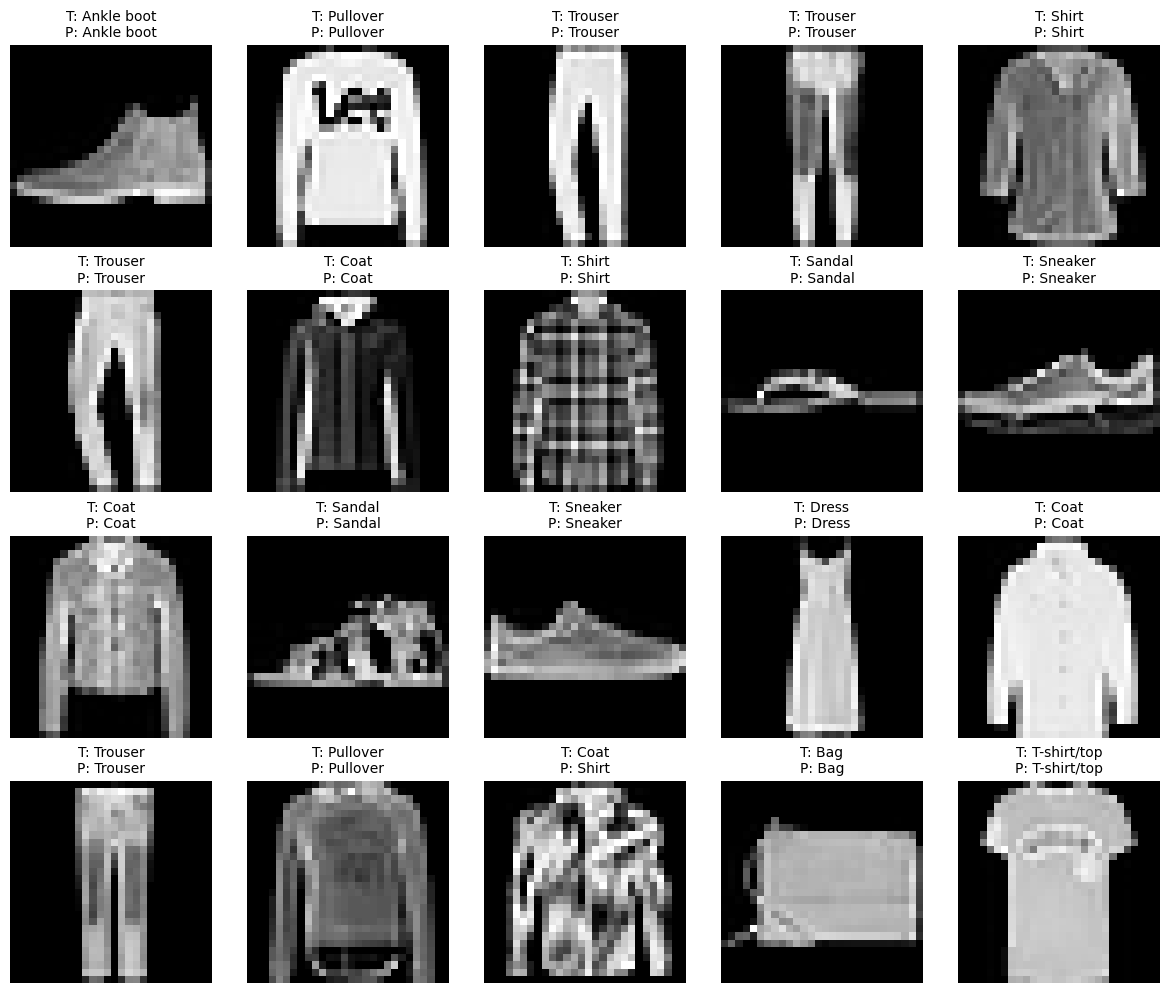

In [39]:
import torch
import matplotlib.pyplot as plt

# Ensure evaluation mode
model.eval()

fig, axes = plt.subplots(4, 5, figsize=(12, 10))

with torch.no_grad():
    for i in range(20):
        image, label = testing_dataset[i]
        image = image.to(device)

        # Add batch dimension
        image_batch = image.unsqueeze(0)

        # Predict
        output = model(image_batch)
        _, pred = torch.max(output, 1)

        # Plot
        ax = axes[i // 5, i % 5]
        ax.imshow(image.cpu().squeeze(), cmap="gray")
        ax.set_title(
            f"T: {class_names[label]}\nP: {class_names[pred.item()]}",
            fontsize=10
        )
        ax.axis("off")

plt.tight_layout()
plt.show()


In [40]:
from sklearn.metrics import classification_report, f1_score

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())


In [41]:
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))


              precision    recall  f1-score   support

 T-shirt/top       0.90      0.84      0.87      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.93      0.82      0.87      1000
       Dress       0.91      0.93      0.92      1000
        Coat       0.86      0.89      0.87      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.72      0.82      0.77      1000
     Sneaker       0.93      0.99      0.96      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.99      0.94      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [42]:
f1 = f1_score(y_true, y_pred, average="weighted")
print("Weighted F1-score:", f1)


Weighted F1-score: 0.9187992035838369
